In [1]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from keyname import keyname as kn
from matplotlib import colors as mpl_colors
from teeplot import teeplot as tp

import Bio
import csv
import glob
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
import urllib.request as request

### define pyplot parameters

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (15, 20)
plt.rcParams["font.size"] = 13
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams["lines.linewidth"] = 2
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

# get data

## get morphologies

In [3]:
morphs = {x['stint']: x[' morph'][1:] for x in pd.read_csv('morphs_by_stint.csv').to_dict(orient='records')}

## get data

In [4]:
# s3_handle = boto3.resource(
#     's3',
#     region_name="us-east-2",
#     config=botocore.config.Config(
#         signature_version=botocore.UNSIGNED,
#     ),
# )
# bucket_handle = s3_handle.Bucket('prq49')

# series_profiles, = bucket_handle.objects.filter(
#     Prefix=f'endeavor=16/noncritical-phenotypeneutral-nopinterpolation-competitions/stage=6+what=collated/stint=40',
# )

In [5]:
filenames = glob.glob("dump/stint=*/*/a=genome+criteria=abundance+*thread=0*.json")

# preprocess data


In [6]:
stint_tags = {}
for filename in filenames:
    file_data = kn.unpack(filename)
    with open(filename, 'r') as file:
        data = json.load(file)
        data = data['value0']['event_tags']['tags']
        tags = [v['value0']['value0'] for k, v in data.items()]
        stint_tags[file_data['stint']] = tags
stint_tags = {int(k): v for k, v in stint_tags.items()}
stint_tags = dict(sorted(stint_tags.items()))
del stint_tags[101]
del stint_tags[102]

# generate distance matrix

## we're using hamming distance

In [7]:
def hamming_distance(a, b):
    return (a ^ b).bit_count()

## calculate all pairwise distances and store them in the matrix

In [8]:
matrix = np.zeros((len(stint_tags), len(stint_tags)))
pairwise = itertools.combinations(list(stint_tags.keys()), 2)

for a, b in pairwise:
    matrix[a][b] = sum(hamming_distance(x, y) for x, y in zip(stint_tags[a], stint_tags[b]))

## graph distance matrix

teeplots/./cmap=blues+linecolor=88888820+viz=heatmap+ext=.pdf
teeplots/./cmap=blues+linecolor=88888820+viz=heatmap+ext=.png


<AxesSubplot:>

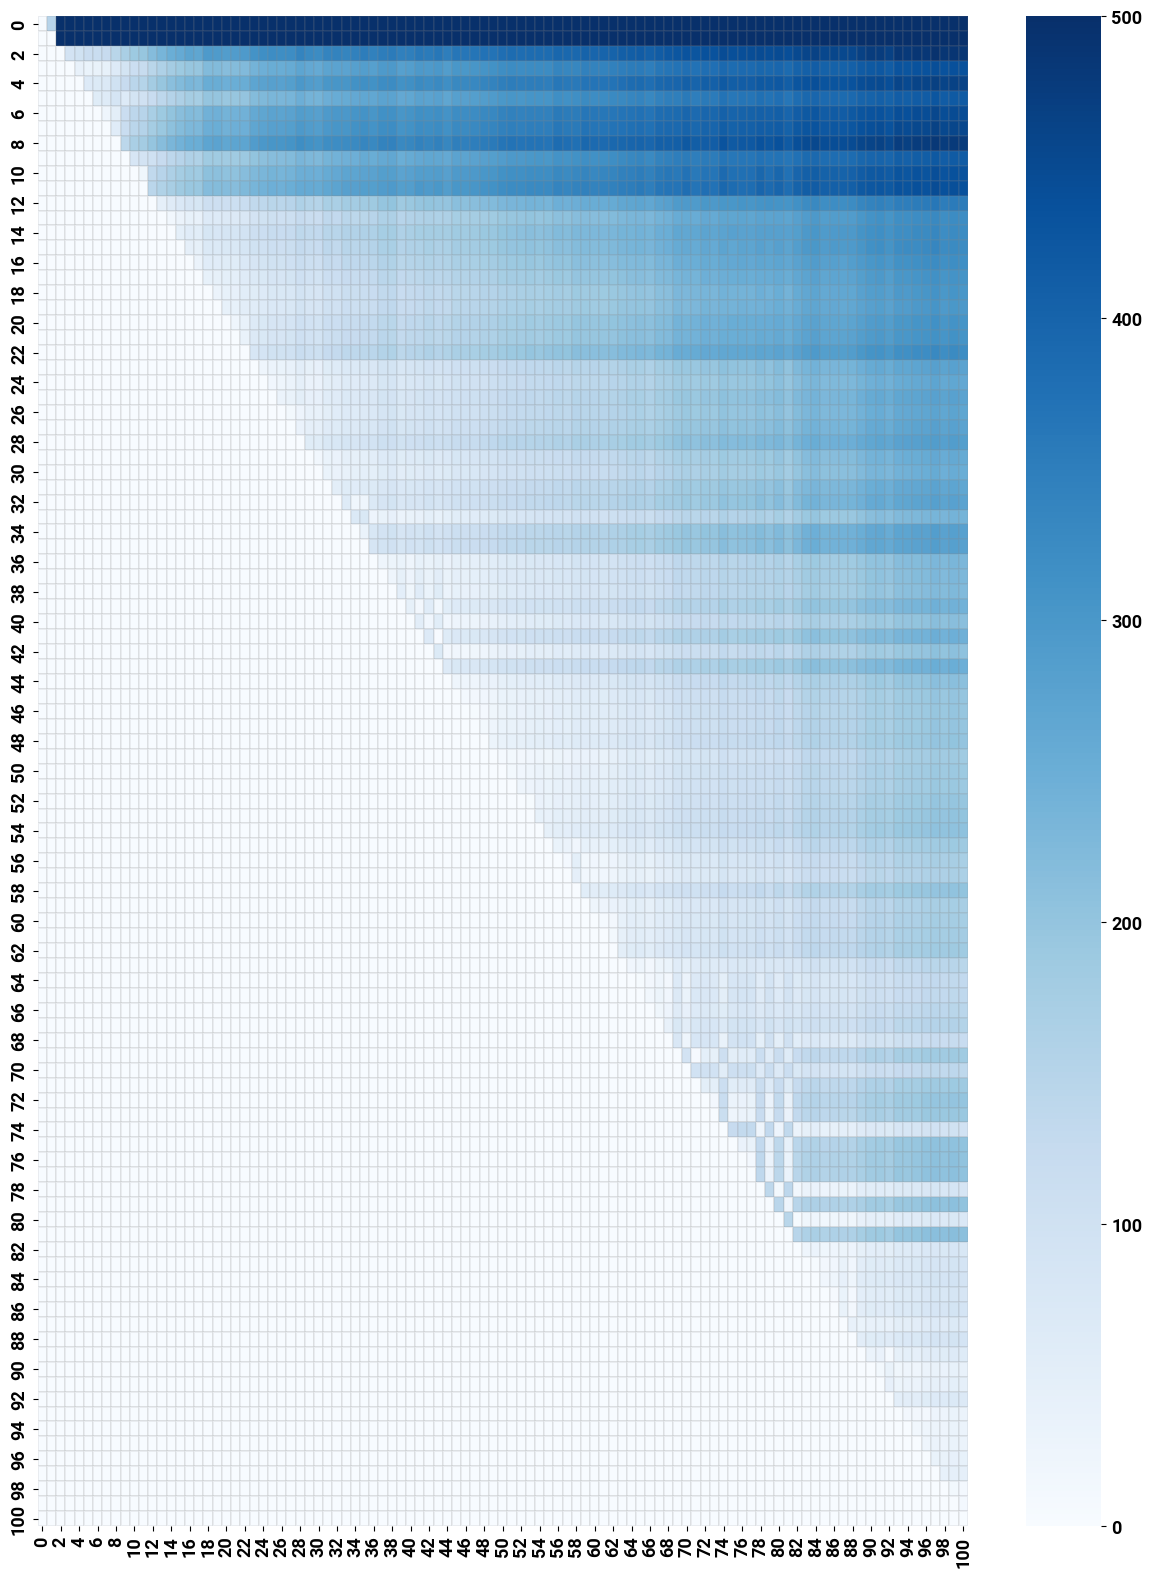

In [9]:
tp.tee(
    sns.heatmap,
    matrix,
    vmax=500,
    linewidths=0.05,
    linecolor='#88888820',
    cmap='Blues'
)

# generate phylogenetic tree

In [10]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0.0]
        for row_idx, row in enumerate(matrix.tolist())
    ]

def set_color(x):
    return mpl_colors.to_hex('C' + str(ord(x[-2]) - ord('a')))

def fix_branch_length(root):
    if 'Inner' not in root.name:
        root.branch_length = 1
    else:
        root.branch_length = sum([x.branch_length for x in root]) / len([x.branch_length for x in root])
    for x in root:
        fix_branch_length(x)

def find_leaves(root):
    nodes = []
    for node in root.clades:
        if 'Inner' not in node.name:
            nodes.append(int(node.name))
        nodes.extend(find_leaves(node))
    return nodes



In [11]:
dm = Bio.Phylo.TreeConstruction.DistanceMatrix(
    names=[str(x) for x in range(len(stint_tags))],
    matrix=to_tril(matrix.T)
)
# tree = getattr(DistanceTreeConstructor(), 'upgma')(dm)
tree = getattr(DistanceTreeConstructor(), 'nj')(dm)

In [12]:
node_counts = {}

class MyTreeMixin(Bio.Phylo.BaseTree.TreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTreeMixin, self).__init__(*args, **kwargs)
    def fix_inner_nodes(self):
        global node_counts
        if 'Inner' in self.root.name:
            leaves = find_leaves(self.root)
            min_leaf = min(leaves, default='0')
            name = 'Inner' + str(min_leaf)
            if name in node_counts:
                node_counts[name] += 1
            else:
                node_counts[name] = 1
            self.root.name = name + "-" + str(node_counts[name])
        for node in self.root.clades:
            node.__class__ = MyClade
            node.fix_inner_nodes()
    def sort_tree(self, reverse=False):
        self.root.clades.sort(key=lambda x: int("".join(filter(str.isdigit, x.name))), reverse=reverse)
        for node in self.root.clades:
            node.__class__ = MyClade
            node.sort_tree(reverse=reverse)
class MyTree(Bio.Phylo.BaseTree.Tree, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTree, self).__init__(*args, **kwargs)
class MyClade(Bio.Phylo.BaseTree.Clade, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyClade, self).__init__(*args, **kwargs)

In [13]:
# fix_branch_length(tree.clade)       

new_tree = MyTree(root=tree.clade)
new_tree.fix_inner_nodes()
new_tree.collapse_all(lambda n: n.name == 'Inner0-7')
new_tree.collapse_all(lambda n: n.name == 'Inner0-6')
new_tree.collapse_all(lambda n: n.name == 'Inner0-5')
new_tree.collapse_all(lambda n: str(n.name) == '0')
new_tree.collapse_all(lambda n: str(n.name) == '1')
new_tree.sort_tree(reverse=False)
# new_tree.root_with_outgroup("Inner2")

def print_tree(root):
    print(root)
    for node in root:
        print_tree(node)
print_tree(new_tree.clade)

Inner0-1
Inner0-2
Inner0-3
Inner0-4
0
1
Inner56-1
Inner56-2
57
Inner56-3
56
59
Inner60-1
60
Inner61-1
61
62
Inner63-1
63
Inner64-1
Inner64-2
Inner64-3
64
65
Inner68-1
70
Inner68-2
68
Inner74-1
74
Inner78-1
78
Inner80-1
Inner80-2
Inner80-3
80
82
Inner83-1
Inner83-2
83
84
Inner85-1
88
Inner85-2
85
86
Inner87-1
87
Inner89-1
Inner89-2
89
92
Inner90-1
Inner90-2
90
91
Inner93-1
Inner93-2
97
Inner93-3
94
Inner93-4
95
Inner93-5
93
96
Inner98-1
98
Inner99-1
99
100
Inner66-1
66
67
Inner69-1
Inner69-2
69
71
Inner72-1
Inner72-2
72
73
Inner75-1
75
Inner76-1
Inner76-2
76
77
Inner79-1
79
81
Inner55-1
55
58
Inner2-1
Inner2-2
Inner2-3
Inner2-4
Inner2-5
Inner2-6
Inner2-7
Inner2-8
Inner2-9
Inner2-10
33
Inner2-11
Inner2-12
Inner2-13
Inner2-14
23
Inner2-15
Inner18-1
18
19
Inner2-16
Inner20-1
20
Inner21-1
21
22
Inner2-17
17
Inner2-18
16
Inner2-19
15
Inner2-20
Inner13-1
13
14
Inner2-21
12
Inner2-22
Inner9-1
9
Inner10-1
10
11
Inner2-23
5
Inner2-24
Inner3-1
3
Inner6-1
8
Inner6-2
6
7
Inner2-25
2
4
Inner24-1
24


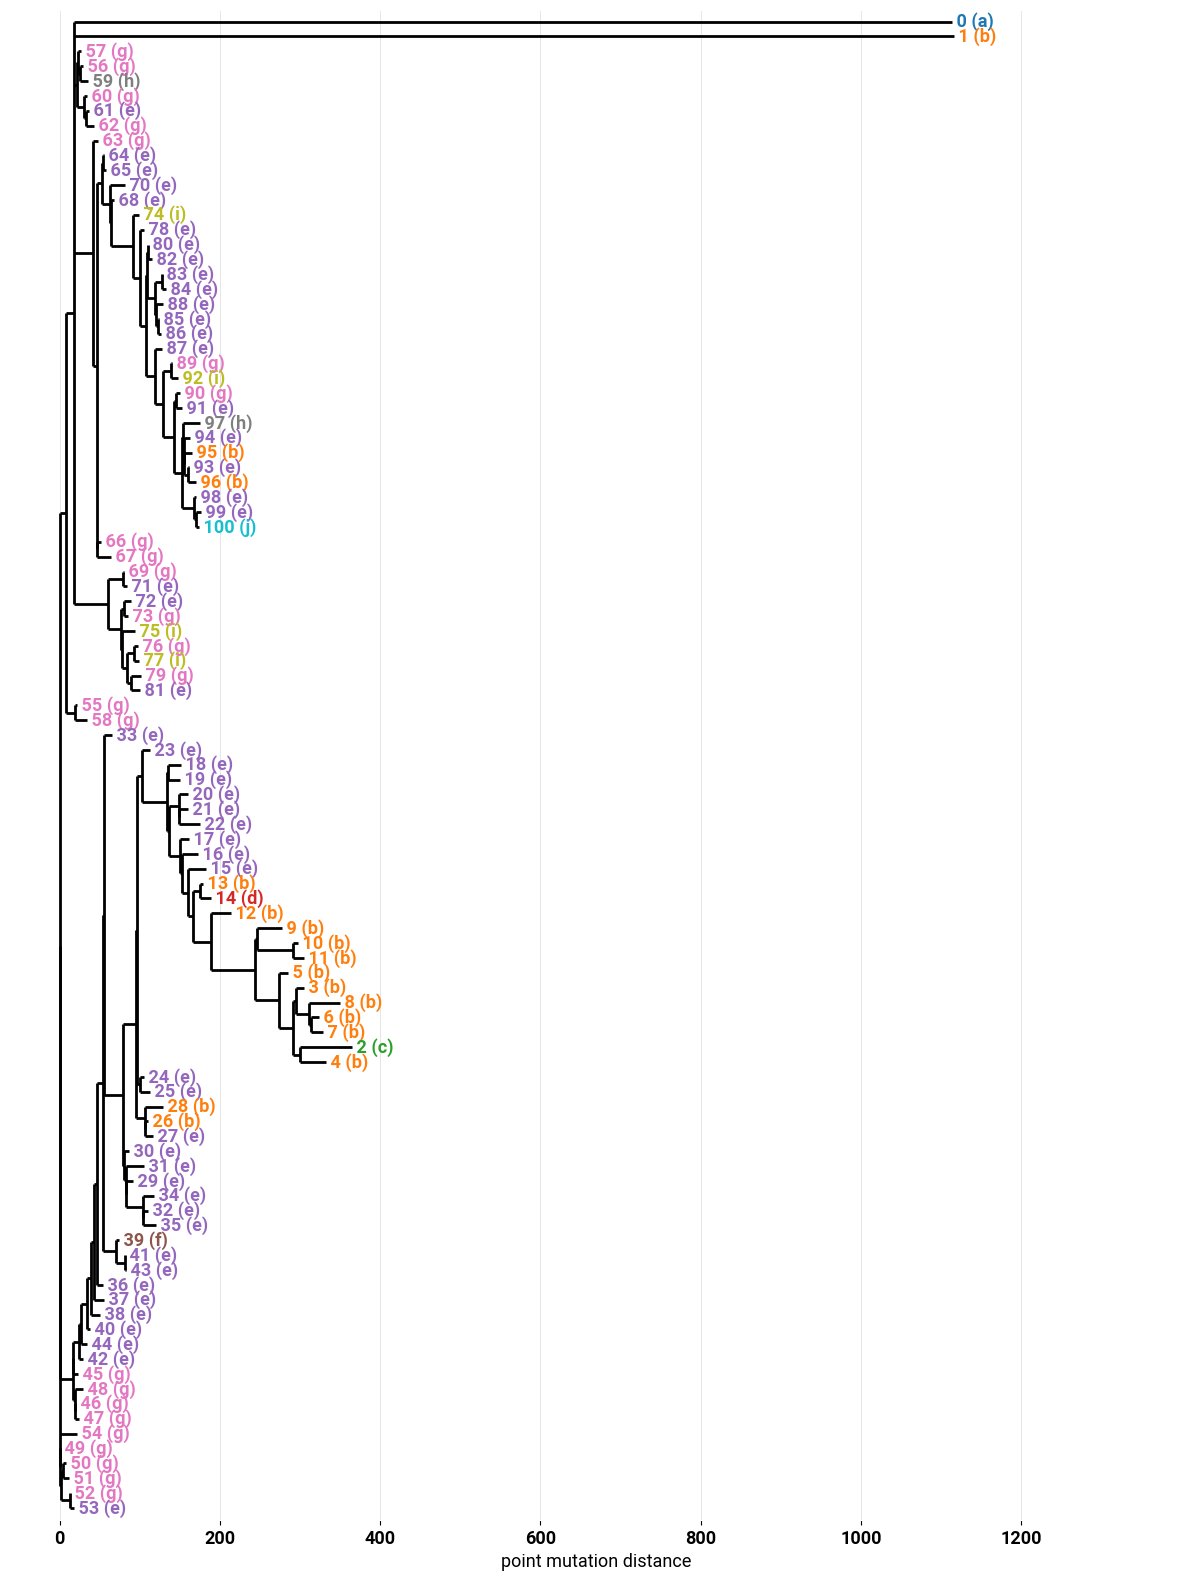

teeplots/./viz=draw+ext=.pdf
teeplots/./viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [14]:
tp.tee(
    Phylo.draw,
    new_tree,
#     tree,
    label_func=lambda x: str(x) + " (" + morphs[int(x.name)] + ")" if 'Inner' not in str(x) else None,
    branch_labels=None,
    label_colors=lambda x: set_color(x),
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)